# Welcome to ID of MBL

We have assembled the code neccessary for repuducing our plots from the paper

The code is presented in 5 sections:

0. Notes
1. Problem Sketch
2. Data Generation
3. EigenComponent Dominance
4. "How to go from eigenstate to ID"-figure, with subplot with 2NN fit
5. ID Scaling Collapse -> inset in not-collapsed
6. !! fig 4: 2NN degen. mitigation

## 0. Notes
* The notebook should be self-contained (w/ import utils.py) ... or does it have to be?

In [3]:
# packages
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils_paper import *
import fssa

## 1. Problem Sketch
If we have points laying in a 3-dimensional coordinate system but confined to a plane, the extrinsic dim. is 3 but the intrinsic dim. is 2.

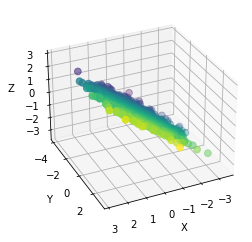

In [4]:
num_points = 1000
x, y = np.random.randn(num_points), np.random.randn(num_points)
z = x

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z, c=y, s=45)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(30, 65)
plt.show()

# 2. generating data

In [23]:
L = 10

In [24]:
seeds = 10 
min_disorder, max_disorder, steps = 0.5, 5.5, 11
location = 'data'
ws=np.linspace(min_disorder, max_disorder, steps)

In [25]:
buildDiagSave(L, seeds, min_disorder, max_disorder, steps, method = 'dense', location = 'data')

100%|██████████| 11/11 [00:02<00:00,  4.50it/s]


## 3. EigenComponent Dominance
We may investigate whether there is a change in intrinsic dimension across the phase transition by looking at the weight distribution within eigenvectors. A decrease in intrinsic dimension is indicated by a consolidation of weight in an eigenvector.

In [26]:
num_lims=8
lims=np.logspace((1-num_lims),0,num_lims)
maxs = np.zeros((steps, seeds))
lower_than = np.zeros((steps, num_lims, seeds))
for index0, W in tqdm(enumerate(ws)):
    for index1, seed in enumerate(range(seeds)):
        
        filename = location+'/results-L-{}-W-{}-seed-{}.npz'.format(L, W, seed)
        eigs = abs(load_eigs(filename, 'vecs').flatten())
        maxs[index0,index1] = np.max(eigs)
        for index2, lim in enumerate(lims):
            count = count_lower_than(eigs, lim)
            lower_than[index0,index2, index1] = count
means = np.mean(lower_than, axis=2).T/binomial(L)**2
lower_than.shape, maxs.shape

11it [00:08,  1.32it/s]


((11, 8, 10), (11, 10))

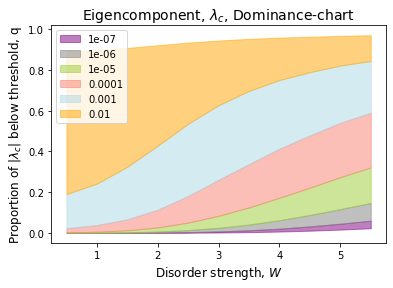

In [27]:
colors = 'orange, lightblue, salmon, yellowgreen, grey, purple'.split(', ')[::-1]
for i, color in zip(range(len(means)), colors):

    plt.fill_between(ws, means[i], means[i+1],
                     label=lims[i],
                     color=color, alpha=.5)
plt.legend(loc='upper left')

plt.xlabel('Disorder strength, $W$', fontsize=12)
plt.ylabel('Proportion of $|\lambda_c|$ below threshold, q', fontsize=12)
plt.title('Eigencomponent, $\lambda_c$, Dominance-chart', fontsize=14)

plt.savefig('figures/Domination-chart-L{}-seeds{},ws{}.png'.format(L,seeds,len(ws)), dpi=500, bbox_inches='tight')

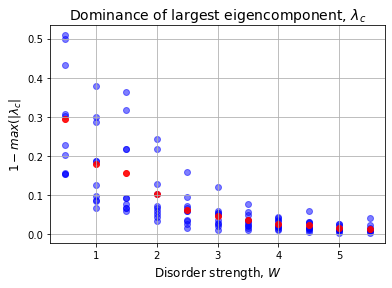

In [28]:
for index, i in enumerate(maxs):
    plt.scatter([ws[index]]*seeds, 1-i, c='b', alpha=0.5)
    plt.scatter([ws[index]], 1-np.mean(i), c='r', alpha=0.9)
    
plt.xlabel('Disorder strength, $W$', fontsize=12)
plt.ylabel('$1-max(|\lambda_c|$', fontsize=12)
plt.title('Dominance of largest eigencomponent, $\lambda_c$', fontsize=14)
plt.grid()

plt.savefig('figures/Domination-chart1-L{}-seeds{},ws{}.png'.format(L,seeds,len(ws)), dpi=500, bbox_inches='tight')

## 4. 2NN
2NN is a neighbour graph algo. which determines the intrinsic dimension of a dataset -- when applied to a list of eigenvectors corresponding to one realization of a single disorder strength.

Additionally we determine quality of the fit!

In [29]:
### 3.1 First we try with a single state config.

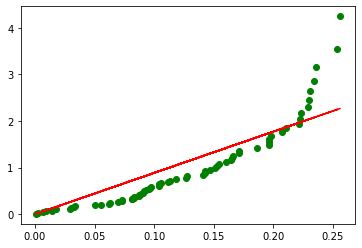

In [42]:
filename = location+'/results-L-{L}-W-{W}-seed-{seed}.npz'.format(L=8, W=ws[0], seed=3)
eigs = load_eigs(filename, 'vecs')
x,y,slope = nn2(eigs, plot=True, return_xy=True)

In [31]:
# now we assess quality of the fit :D 
loss = L2_loss_linear_originBound(x,y,slope)
weight = weigt_from_loss(loss)
print(loss, weight)

7.410071540757759 0.1349514636261851


In [32]:
slope_loss_and_weight = np.zeros((len(ws),seeds,3))
for index0, W in tqdm(enumerate(ws)):
    for index1, seed in enumerate(range(seeds)):
        
        filename = location+'/results-L-{}-W-{}-seed-{}.npz'.format(L, W, seed)
        eigs = load_eigs(filename, 'vecs')
        x,y,slope = nn2(eigs, plot=False, return_xy=True)
        loss = L2_loss_linear_originBound(x,y,slope)
        weight = weigt_from_loss(loss)
        slope_loss_and_weight[index0,index1] = np.array([slope,loss,weight])

11it [02:50, 15.52s/it]


In [33]:
slope_loss_and_weight[0,0]

array([49.08367058,  7.41007154,  0.13495146])

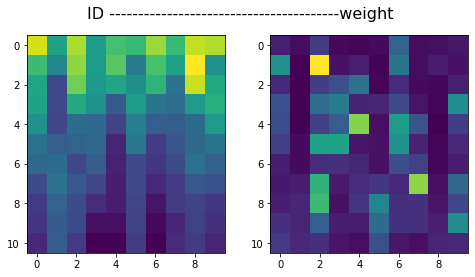

In [34]:
fig, ax = plt.subplots(1,2, figsize=(8,4))


ax[0].imshow(slope_loss_and_weight[:,:,0], ) # disorder on x-axis, seed on y-axis, weight & slope by color or number
ax[1].imshow(slope_loss_and_weight[:,:,2], ) # disorder on x-axis, seed on y-axis, weight & slope by color or number
fig.suptitle('ID ----------------------------------------weight', fontsize=16)
plt.show()

## 4.1. 2NN averaging
By performing 2NN on eigenvectors from many disorder strengths and averaging across many realization, we obtain a general trend. 

We can improve results by including a weight when averaging. The weight is determined by the quality of individual 2NN fits.

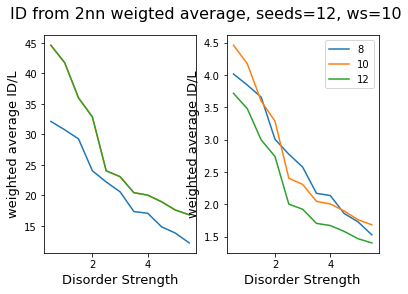

In [35]:
def weighted_average_m1(distribution, weights): 
    # https://towardsdatascience.com/3-ways-to-compute-a-weighted-average-in-python-4e066de7a719
    numerator = sum([distribution[i]*weights[i] for i in range(len(distribution))])
    denominator = sum(weights)
    
    return numerator/denominator

weighted_averages = []
for i in range(len(ws)):
    weighted_averages.append(weighted_average_m1(slope_loss_and_weight[i,:,0], slope_loss_and_weight[i,:,2]))
    
np.save('data/weighted_averages-L={}-seeds={}-ws={}.npy'.format(L,seeds,len(ws)),weighted_averages, allow_pickle=True)

fig, ax = plt.subplots(1,2)
for L in [8,10,12]:
    ax[0].plot(ws,np.load('data/weighted_averages-L={}-seeds={}-ws={}.npy'.format(L,seeds,len(ws))), label=L)
    ax[1].plot(ws,np.load('data/weighted_averages-L={}-seeds={}-ws={}.npy'.format(L,seeds,len(ws)))/L, label=L)
plt.legend()
[ax[i].set_xlabel('Disorder Strength', fontsize=13) for i in range(2)]
[ax[i].set_ylabel('weighted average ID/L', fontsize=13) for i in range(2)]

fig.suptitle('ID from 2nn weigted average, seeds={}, ws={}'.format(L,seeds,len(ws)), fontsize=16)
plt.show()

## 5. Scaling collapse
To obtain the critical disorder strength, we may collapse the fits from **4.**

### 5.1. Scaling Template

see: https://pyfssa.readthedocs.io/en/stable/tutorial.html

[array([32.13125844, 30.76161683, 29.26865359, 24.04495956, 22.20446634,
       20.60447448, 17.35493834, 17.08103827, 14.86238695, 13.82807782,
       12.21871642]), array([44.61777891, 41.74956922, 35.97838623, 32.87314184, 24.03221414,
       23.07687155, 20.45322308, 20.05138737, 18.96622796, 17.60904225,
       16.82578052]), array([44.61777891, 41.74956922, 35.97838623, 32.87314184, 24.03221414,
       23.07687155, 20.45322308, 20.05138737, 18.96622796, 17.60904225,
       16.82578052])]
autoscale done
Scale data done
Quality check done


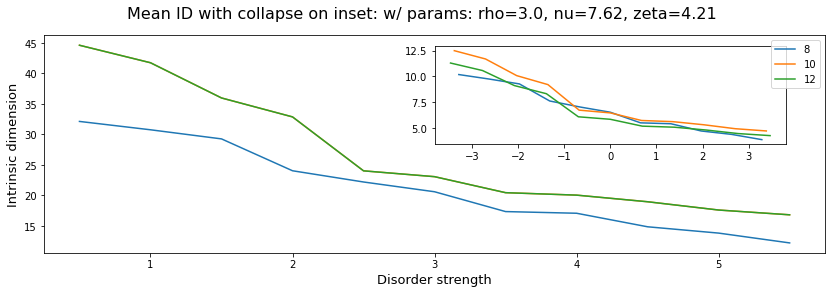

(None, (3, 11))

In [36]:
# Load data (weigted averages)
weighted_averages = []
for L in [8,10,12]:
    data = np.load('data/weighted_averages-L={}-seeds={}-ws={}.npy'.format(L,seeds,len(ws)))
    #plt.plot(ws,data, label=L)
    weighted_averages.append(data)
print(weighted_averages)

weighted_averages = np.array(weighted_averages)
scale_collapse2(weighted_averages, ws), weighted_averages.shape

[array([4.0164073 , 3.8452021 , 3.6585817 , 3.00561994, 2.77555829,
       2.57555931, 2.16936729, 2.13512978, 1.85779837, 1.72850973,
       1.52733955]), array([4.46177789, 4.17495692, 3.59783862, 3.28731418, 2.40322141,
       2.30768715, 2.04532231, 2.00513874, 1.8966228 , 1.76090423,
       1.68257805]), array([3.71814824, 3.47913077, 2.99819885, 2.73942849, 2.00268451,
       1.92307263, 1.70443526, 1.67094895, 1.580519  , 1.46742019,
       1.40214838])]


/Users/antongolles/opt/anaconda3/lib/python3.7/site-packages/fssa/fssa.py:505: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(varco)), varco


autoscale done
Scale data done
Quality check done


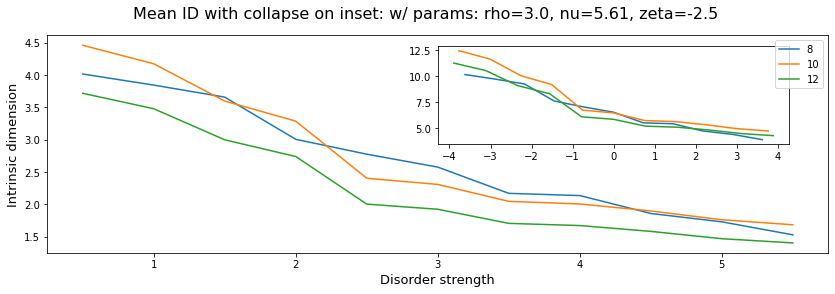

(None, (3, 11))

In [37]:
# Load data (weigted averages)
weighted_averages = []
for L in [8,10,12]:
    data = np.load('data/weighted_averages-L={}-seeds={}-ws={}.npy'.format(L,seeds,len(ws)))
    #plt.plot(ws,data, label=L)
    weighted_averages.append(data/L)
print(weighted_averages)

weighted_averages = np.array(weighted_averages)
scale_collapse2(weighted_averages, ws), weighted_averages.shape


## Lets have a look at the date obtained from the cluster

In [19]:
L = 10
filename = '../fullresults/2nn-{}-combined.npy'.format(L)
data = np.load(filename)
print(data.shape)

print("We can't do a weighted average here, because we didnt note the quality of the fits (2nn)")

(9900, 31)
We can't do a weighted average here, because we didnt note the quality of the fits (2nn)


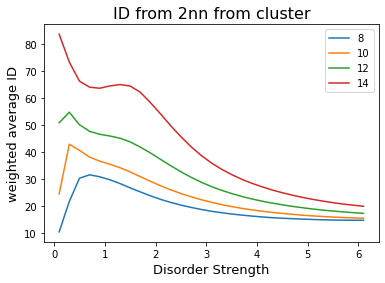

In [20]:
ws2 = np.linspace(0.1,6.1,31)
Ls = [8,10,12,14]
ID_mean = np.zeros((len(Ls),len(ws2)))
for index, L in enumerate(Ls):
    filename = '../fullresults/2nn-{}-combined.npy'.format(L)
    data = np.load(filename)
    averaged = np.mean(data,axis=0)
    ID_mean[index] = averaged
    plt.plot(ws2,averaged, label = L)
plt.legend()
plt.xlabel('Disorder Strength', fontsize=13)
plt.ylabel('weighted average ID', fontsize=13)

plt.title('ID from 2nn from cluster', fontsize=16)
plt.show()

/Users/antongolles/opt/anaconda3/lib/python3.7/site-packages/fssa/fssa.py:505: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(varco)), varco


autoscale done
Scale data done
Quality check done


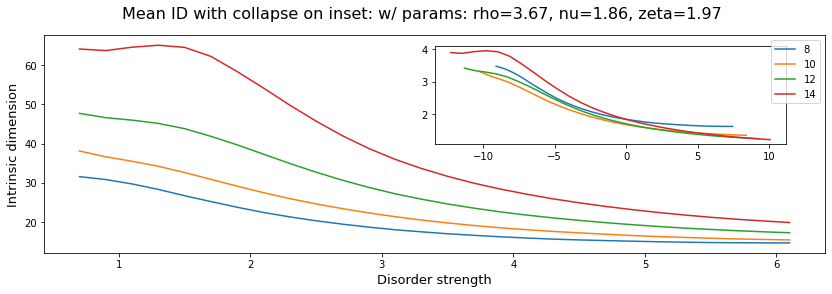

In [21]:
skip_init = 3


scale_collapse2(ID_mean[:,skip_init:], ws2[skip_init:], Ls)



## 6. Degeneracy mitigation
* does it have to be the **nearest** neighbours?

* I have done a little in this regard -- namely weighted averaging
* Alternatively; we could discriminate against very near neighbours --> either by exclusion, or by diminished weight.

In [39]:
## Try TSNE